<a href="https://colab.research.google.com/github/Geethapriya2815/Mental-Health-Tracker-For-Students/blob/main/LSTM_model_(MENTAL_HEALTH_TRACKER_APP_FOR_STUDENTS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     First Name    Last Name  Phone Number                Email  \
0   FirstName62  LastName120  916366156402  user189@example.com   
1  FirstName760  LastName609  917108709220  user758@example.com   
2  FirstName578  LastName324  919815498319  user383@example.com   
3  FirstName655  LastName727  913467665621  user899@example.com   
4  FirstName603  LastName403  919990187446  user493@example.com   

  How often do you feel stress and anxious?  \
0                                    Rarely   
1                                    Always   
2                                     Often   
3                                     Often   
4                                    Rarely   

  What activities do you find helpful in managing stress?  \
0                                              Music        
1                                         Journaling        
2                                              Music        
3                                           Exercise        
4        

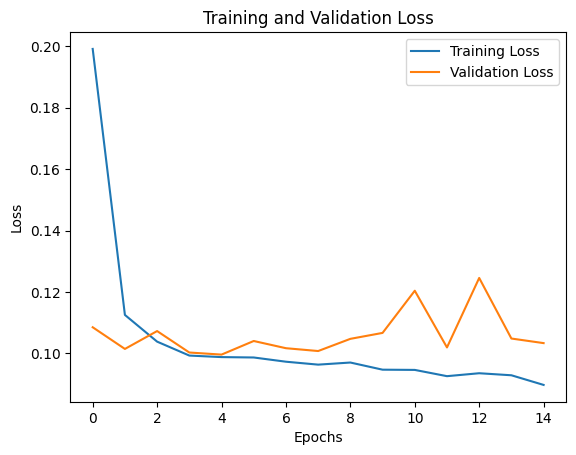

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.1908 - mean_absolute_error: 0.3585
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0997 - mean_absolute_error: 0.2710
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.1004 - mean_absolute_error: 0.2733
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1020 - mean_absolute_error: 0.2754
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0989 - mean_absolute_error: 0.2704
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1011 - mean_absolute_error: 0.2741
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0984 - mean_absolute_error: 0.2694
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0935 - mean_absolute_error: 0.2590
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0935 - mean_absolute_error: 0.2620
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0934 - mean_absolute_error: 0.2623
Epoch 11/100
31/31 ━━━━━━━━━━

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential, Model # Import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention, Concatenate, Input # Import Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
data = pd.read_csv('/mental_health_survey_data_updated.csv')
print(data.head())

# Step 2: Data Preprocessing

# Encode categorical columns
label_columns = [
    "How often do you feel stress and anxious?",
    "What activities do you find helpful in managing stress?",
    "Do you feel supported by your school/university in terms of mental health resources?",
    "How important do you think mental health education is for students?",
    "Are you aware of the mental health services available on campus?",
    "How comfortable are you discussing mental health with your peers?",
    "Have you ever experienced burnout due to academic pressure?",
    "Have you ever sought help for your mental health?"
]

label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Feature Selection
features = [
    "How often do you feel stress and anxious?",
    "What activities do you find helpful in managing stress?",
    "Do you feel supported by your school/university in terms of mental health resources?",
    "How important do you think mental health education is for students?",
    "Are you aware of the mental health services available on campus?",
    "How comfortable are you discussing mental health with your peers?",
    "Have you ever experienced burnout due to academic pressure?",
    "Have you ever sought help for your mental health?"
]
target = "On a scale of 1-10, how would you rate your overall mental well-being currently?"

# Filter relevant data
data = data[features + [target]].dropna()

# Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Step 3: Prepare Data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])  # Features
        y.append(data[i + seq_length, -1])    # Target
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # Increased sequence length for better temporal analysis
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Step 4: Cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 5: Model Creation with Attention Mechanism
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, activation='relu', return_sequences=True)(x)
    x = Attention()([x, x])
    x = LSTM(32, activation='relu')(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Step 6: Hyperparameter Optimization (GridSearchCV/RandomizedSearchCV can be used here)

# Step 7: Training with Early Stopping and Cross-Validation
val_losses = []
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_model((SEQ_LENGTH, X.shape[2]))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    val_losses.append(history.history['val_loss'][-1])

# Average Validation Loss
print(f"Average Validation Loss: {np.mean(val_losses):.4f}")

# Step 8: Plot Results
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 9: Final Evaluation on Test Set
model = create_model((SEQ_LENGTH, X.shape[2]))
model.fit(X, y, epochs=100, batch_size=32, verbose=1)

# Evaluate final model on the test set
loss, mae = model.evaluate(X, y)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Step 10: Predictions and Comparison
y_pred = model.predict(X)

# Reverse Scaling for Predictions and Actuals
# The original data had 9 features (8 features + 1 target)
# X[:, -1, :-1] selects the last sequence's features (excluding the target)
# We need to add a dummy column to match the original number of features

# Create a dummy column with zeros to represent the missing feature
dummy_column = np.zeros((X.shape[0], 1))

y_actual = scaler.inverse_transform(
    np.hstack((X[:, -1, :-1], dummy_column, y.reshape(-1, 1)))  # Add dummy column
)[:, -1]  # Select the target column (last column)


y_pred_actual = scaler.inverse_transform(
    np.hstack((X[:, -1, :-1], dummy_column, y_pred)) # Add dummy column
)[:, -1]  # Select the target column (last column)

# Display a few predictions
# Display a few predictions
for i in range(5):
    print(f"Actual: {y_actual[i]:.2f}, Predicted: {y_pred_actual[i]:.2f}") # Remove [0]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
